In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge \
, Lasso, ElasticNet
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split, cross_val_score \
,GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Load Data

In [3]:
oil_prices = pd.read_csv('./data/oil.csv',
                         date_parser=pd.to_datetime,
                         parse_dates=['date'])
oil_prices.columns = ['date','oil_price']

In [4]:
holidays_events = pd.read_csv('./data/holidays_events.csv',
                              dtype={'type': 'category',
                                     'locale': 'category',
                                     'locale_name': 'category',
                                     'description': 'category',
                                     'transferred': 'bool'},
                              date_parser=pd.to_datetime,
                              parse_dates=['date'])

In [5]:
stores_data = pd.read_csv('./data/stores.csv',
                         dtype={'store_nbr': 'category',
                                'city': 'category',
                                'state': 'category',
                                'type':'category',
                                'cluster':'category'})

In [6]:
transactions = pd.read_csv('./data/transactions.csv', dtype={'store_nbr': 'category'},
                           date_parser=pd.to_datetime,
                           parse_dates=['date'])          
transactions = transactions.groupby(['date','store_nbr']).sum()

In [7]:
df_train = pd.read_csv('./data/train.csv',
                       dtype={'store_nbr': 'category',
                              'family': 'category',
                              'sales': 'float32'},
                       date_parser=pd.to_datetime,
                       parse_dates=['date'])

In [8]:
df_test = pd.read_csv('./data/test.csv',
                       dtype={'store_nbr': 'category',
                              'family': 'category'},
                       date_parser=pd.to_datetime,
                       parse_dates=['date'])

In [9]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# Data Wrangling/FE

***Create holidays***

In [10]:
true_holidays_days = holidays_events.loc[holidays_events['transferred']==False]

def create_holidays(df,thd=true_holidays_days):
    df['holidays'] = df['date'].isin(thd['date'])
    return df

In [11]:
df_train_copy = create_holidays(df_train_copy)
df_test_copy = create_holidays(df_test_copy)

***Create day,month,quarter,payday etc***

In [12]:
def create_date_vars(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['payday'] = (df['date'].dt.is_month_end) | (df['day']==15)
    df['dayoftheweek'] = df['date'].dt.dayofweek +1 #Monday=1, Sunday=7
    return df

In [13]:
df_train_copy = create_date_vars(df_train_copy)
df_test_copy = create_date_vars(df_test_copy)

***Create coordinates of day,week,month,quarter***

In [14]:
def create_coords(df):
    df['dayofthemonth_x'] = df.apply(lambda x: np.sin(np.pi*int(x['day'])/x['date'].days_in_month),axis=1)
    df['dayofthemonth_y'] = df.apply(lambda x: np.cos(np.pi*int(x['day'])/x['date'].days_in_month),axis=1)
    df['month_x'] = df['month'].apply(lambda x: np.sin(np.pi*int(x)/12) )
    df['month_y'] = df['month'].apply(lambda x: np.cos(np.pi*int(x)/12) )
    df['dayoftheweek_x'] = df['dayoftheweek'].apply(lambda x: np.sin(np.pi*int(x)/7) )
    df['dayoftheweek_y'] = df['dayoftheweek'].apply(lambda x: np.cos(np.pi*int(x)/7) )
    df['quarter_x'] = df['quarter'].apply(lambda x: np.sin(np.pi*int(x)/4) )
    df['quarter_y'] = df['quarter'].apply(lambda x: np.cos(np.pi*int(x)/4) )
    return df

In [15]:
df_train_copy = create_coords(df_train_copy)
df_test_copy = create_coords(df_test_copy)

***Transactions***

*Prediction for df_test*

In [16]:
trans_pred = transactions.unstack(['store_nbr'])
trans_pred = trans_pred.loc[trans_pred.index>='2015-06-01']
trans_pred = trans_pred.reset_index()
trans_pred['date'] = trans_pred['date'].dt.to_period('D')
trans_pred = trans_pred.set_index('date')

In [17]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=trans_pred.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [18]:
model = LinearRegression(fit_intercept=False)
model.fit(X, trans_pred)

LinearRegression(fit_intercept=False)

In [19]:
X_pred = dp.out_of_sample(steps=16)
X_pred.index.name = 'date'

In [20]:
trans_predicted = pd.DataFrame(model.predict(X_pred), index=X_pred.index, columns=trans_pred.columns)
trans_predicted = trans_predicted.stack(['store_nbr'])
trans_predicted['transactions'] = trans_predicted['transactions'].astype('int32')

In [21]:
transactions_predicted_to_join = trans_predicted.reset_index()
transactions_predicted_to_join['date']=transactions_predicted_to_join['date'].dt.to_timestamp()
df_test_copy = pd.merge(df_test_copy, transactions_predicted_to_join, 
                        how='left', on=['date','store_nbr'])

*Transactions for df_train*

In [22]:
transactions_to_join = transactions.reset_index()

In [23]:
df_train_copy = pd.merge(df_train_copy, transactions_to_join, how='left', 
                         on=['date','store_nbr'])

In [24]:
df_train_copy['transactions'].isna().value_counts()

transactions
False    2997324
True        3564
Name: count, dtype: int64

In [25]:
df_train_copy.loc[df_train_copy['date']=='2016-01-01','transactions']=0
df_train_copy.loc[df_train_copy['transactions'].isna(),'transactions']=0
df_train_copy['transactions']=df_train_copy['transactions'].astype('int32')

# EDA

In [26]:
average_sales = df_train_copy.groupby('date').mean('sales')[['sales']]
average_transactions = transactions.reset_index().groupby('date').mean('transactions')[['transactions']]

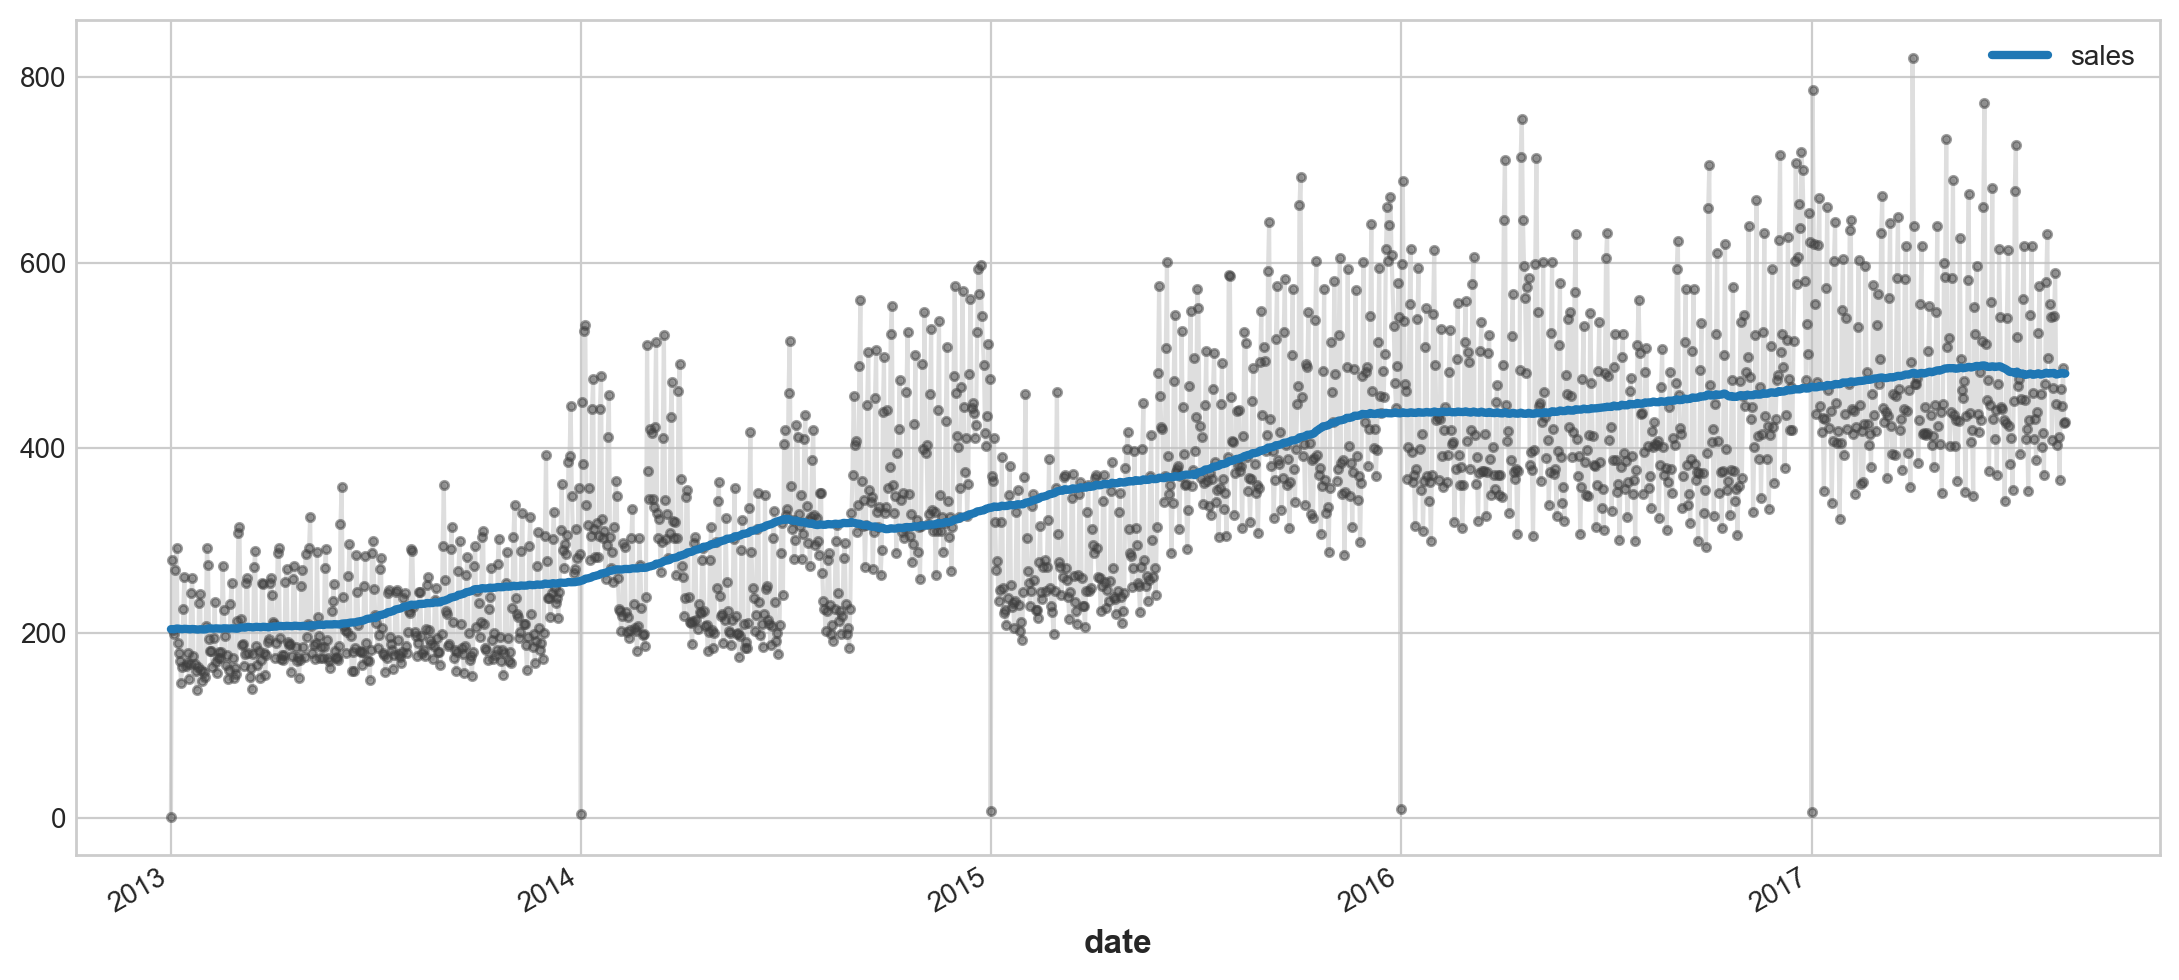

In [27]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

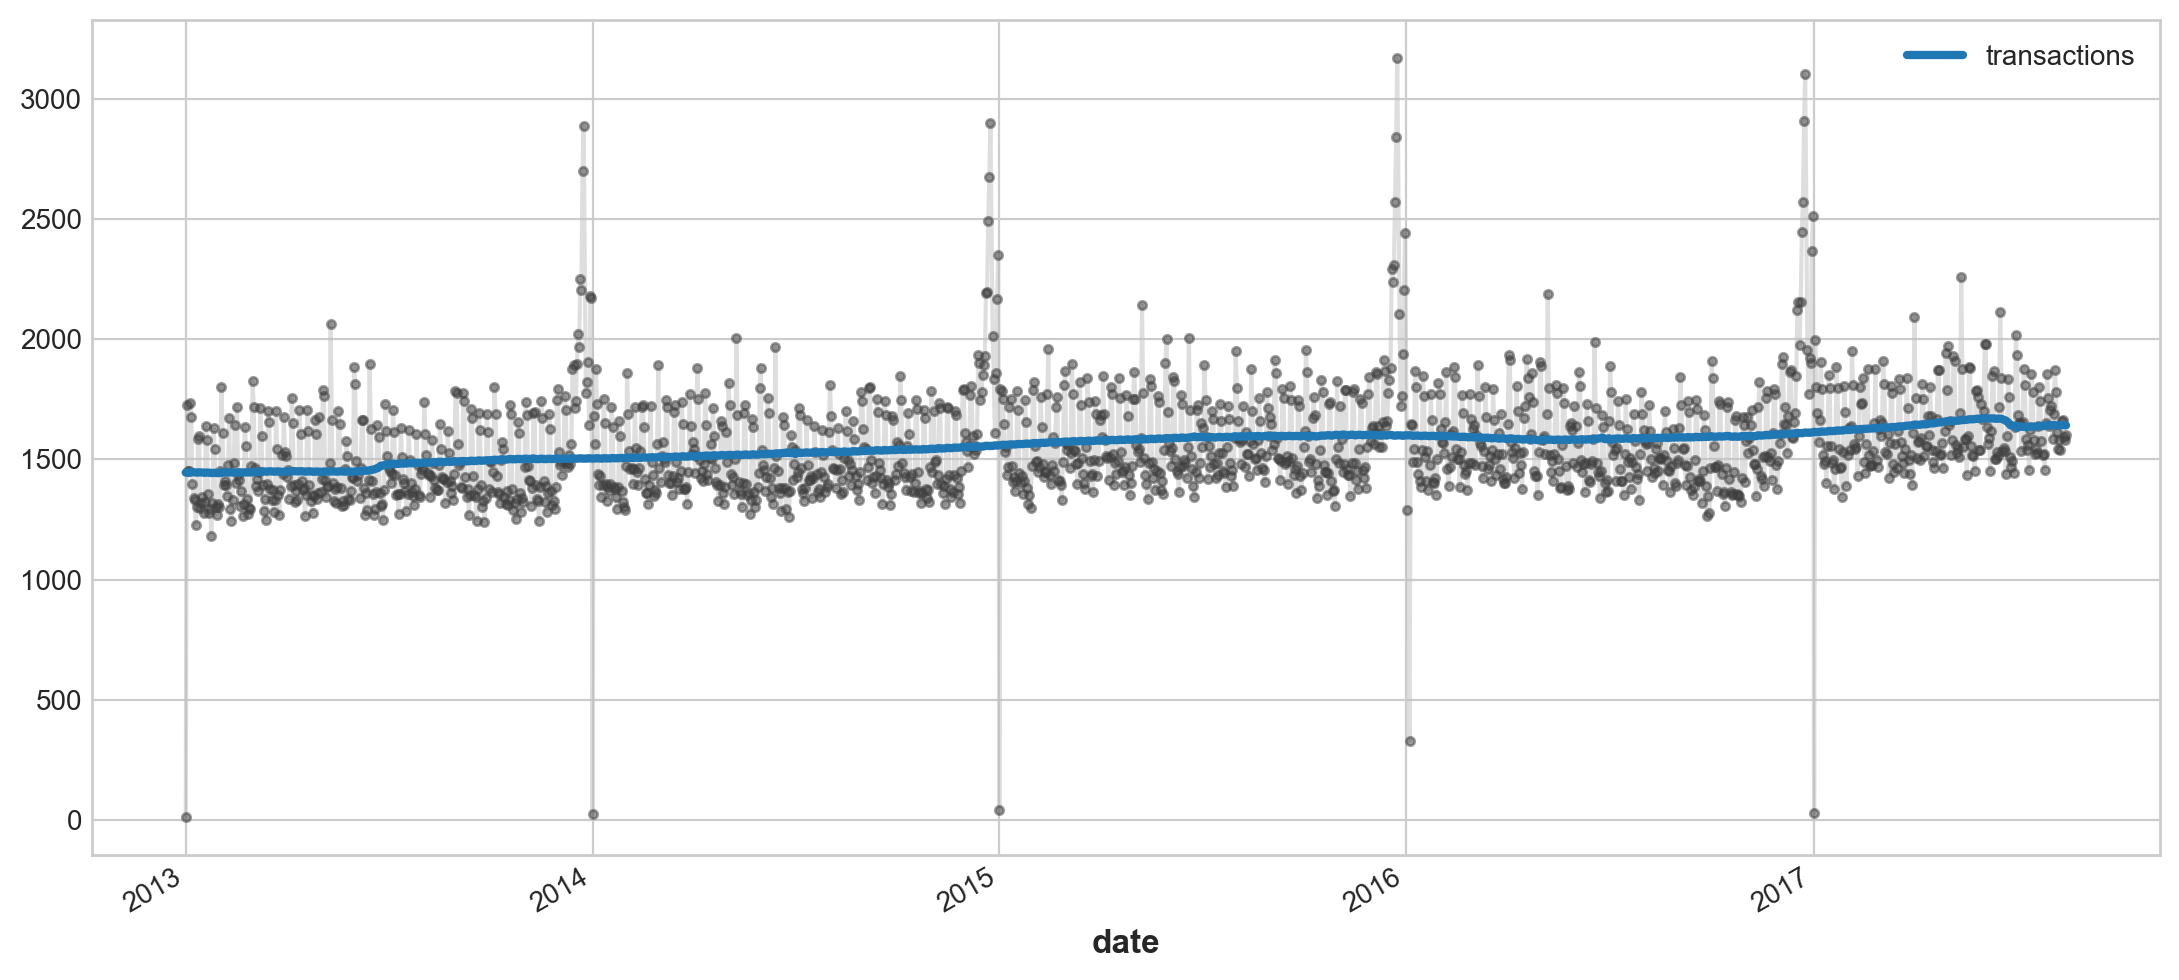

In [28]:
trend = average_transactions.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_transactions.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# Outliers

In [29]:
average_sales_since_2015 = average_sales.loc[average_sales.index>='2015-06-01']

In [30]:
average_transactions_since_2015 = average_transactions.loc[average_transactions.index>='2015-06-01']

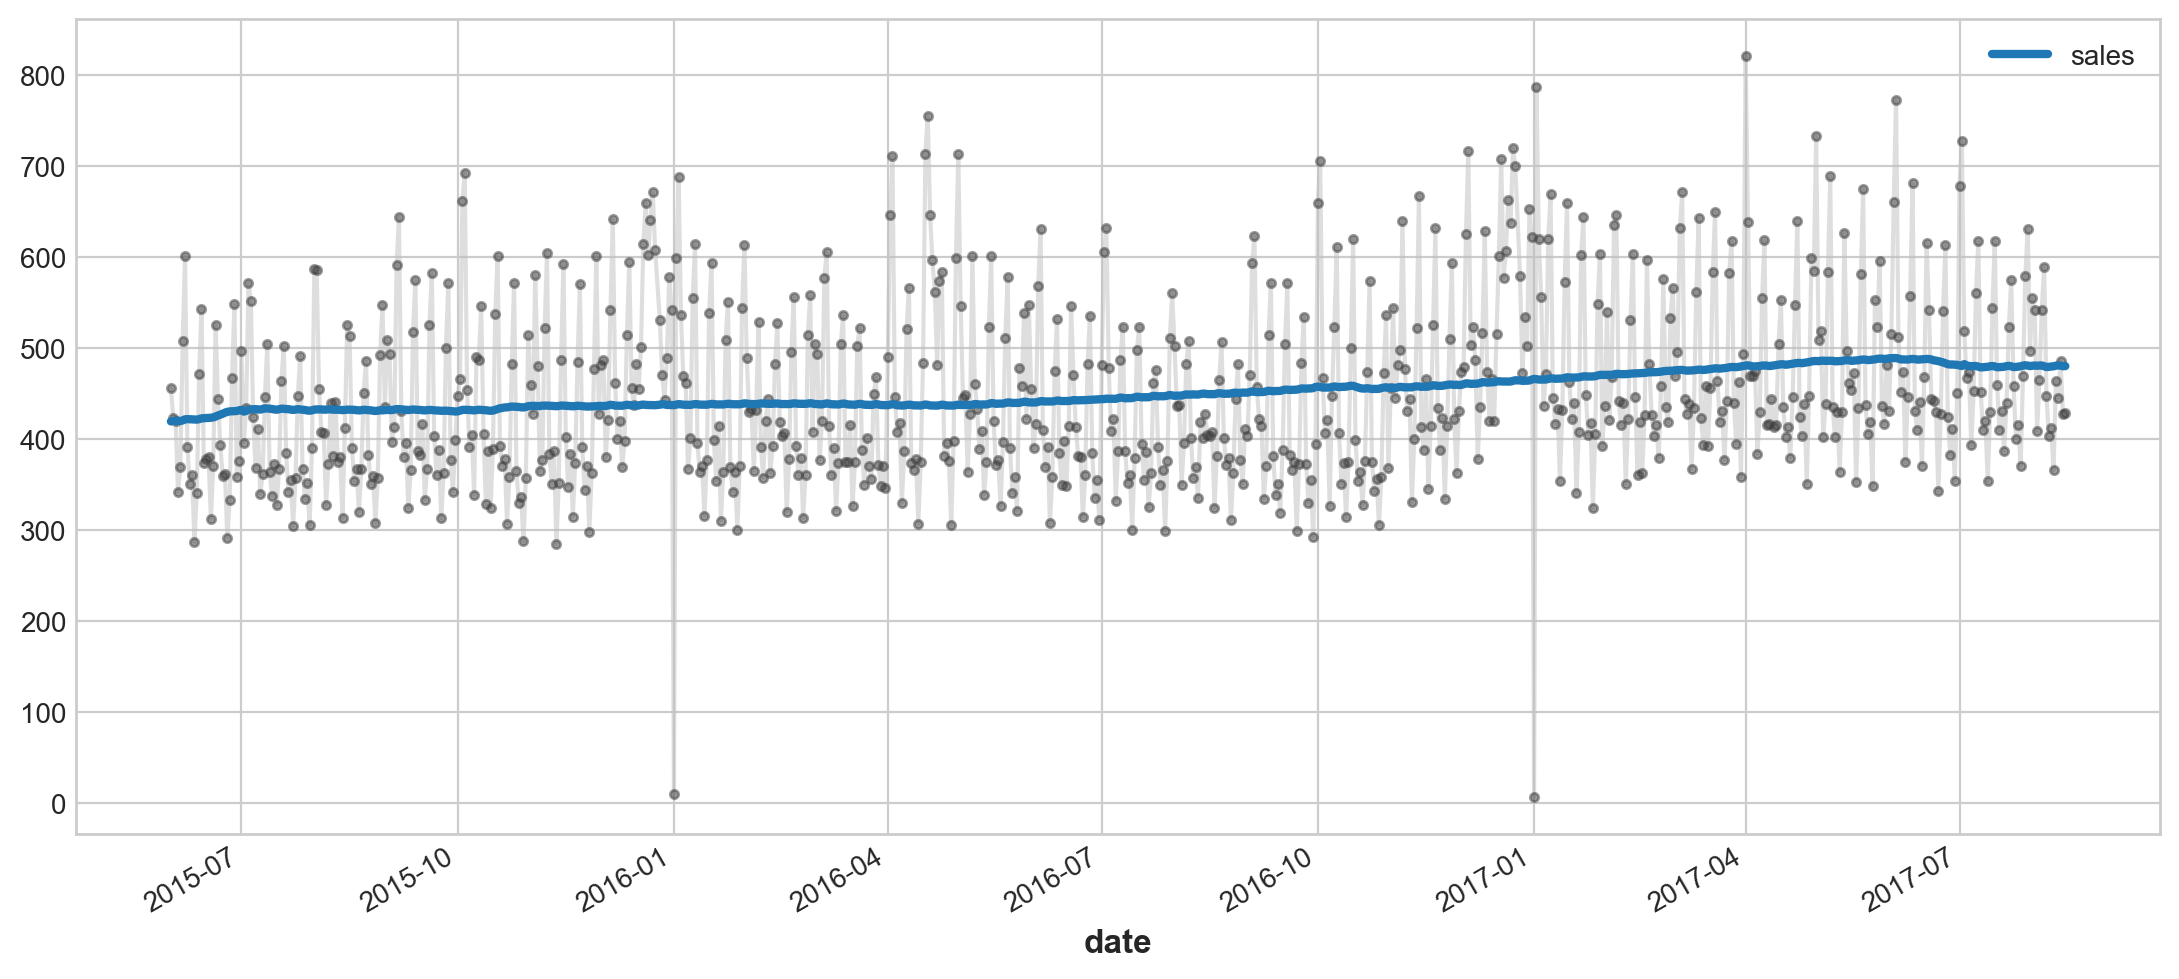

In [31]:
trend = average_sales_since_2015.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales_since_2015.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

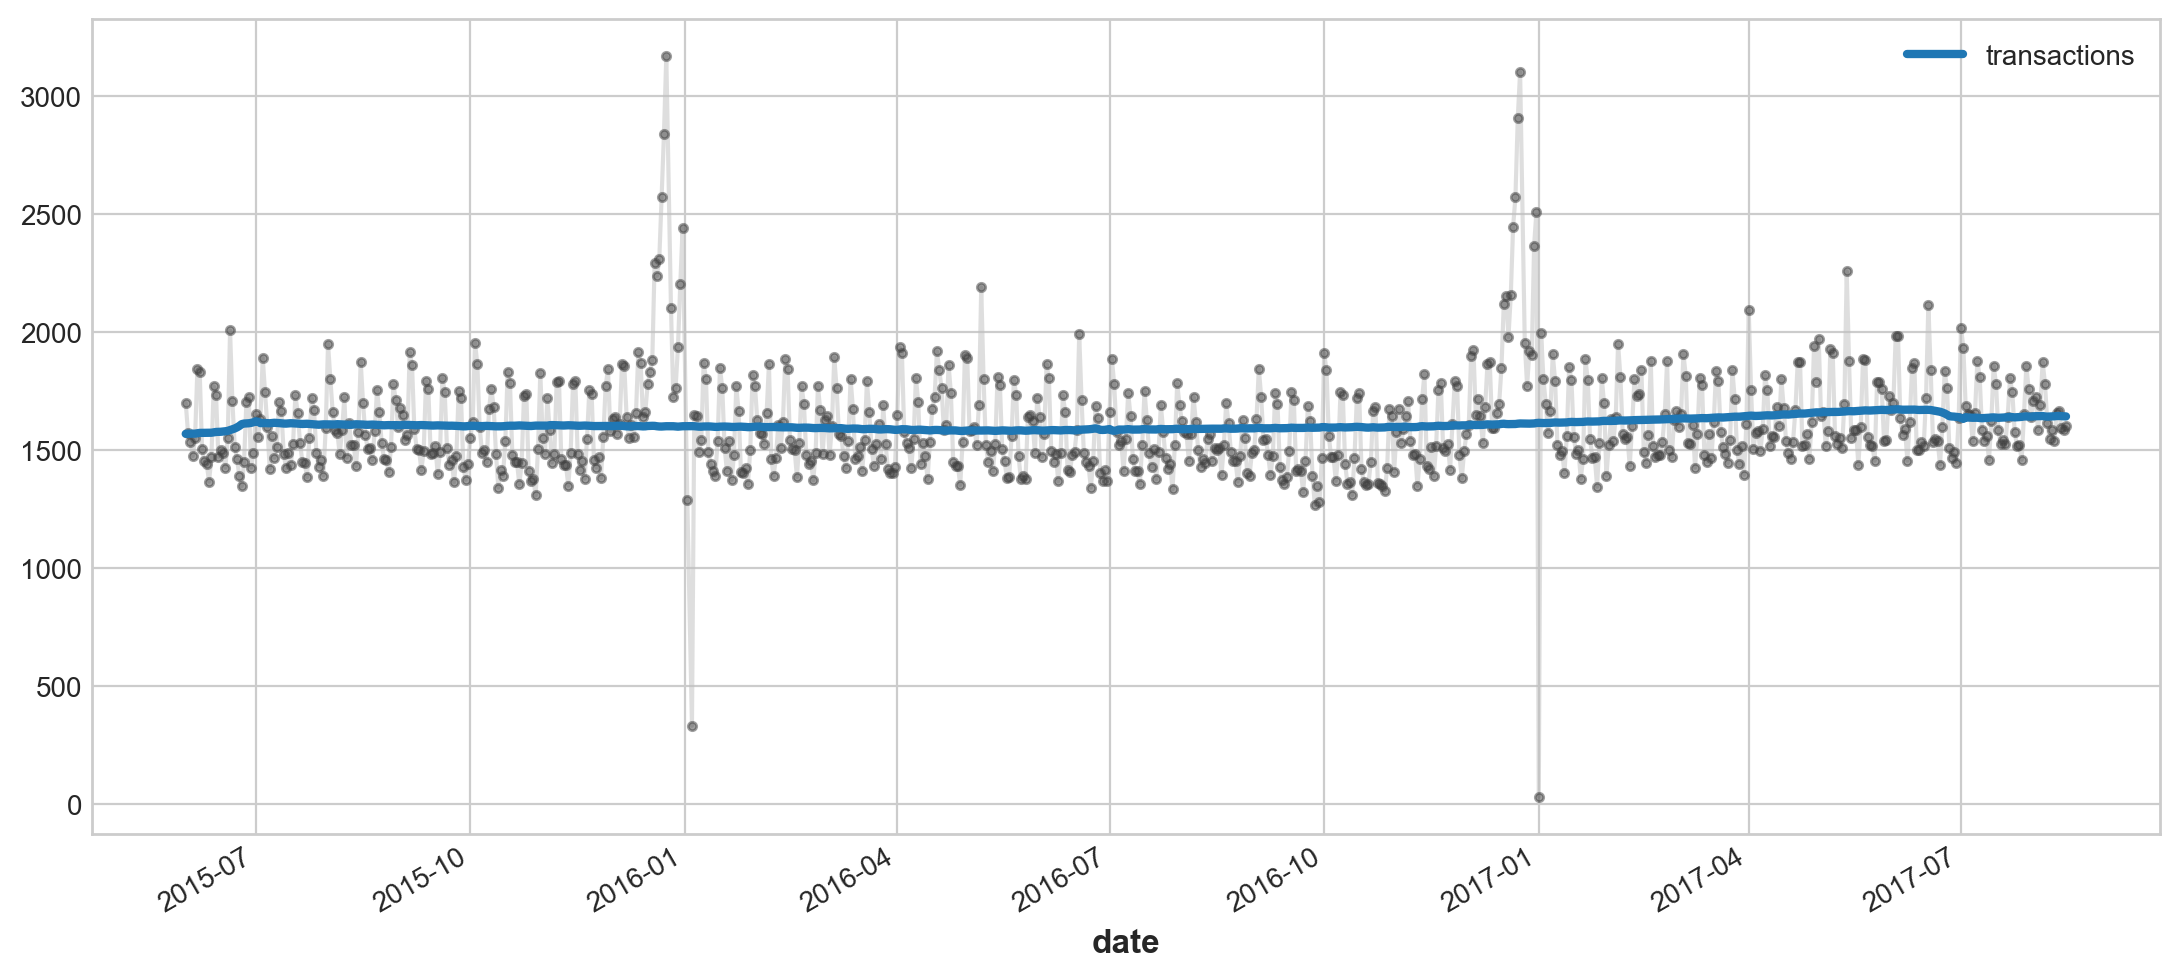

In [32]:
trend = average_transactions_since_2015.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_transactions_since_2015.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [33]:
average_sales_since_2015['z_score'] = stats.zscore(average_sales_since_2015['sales'])
average_sales_since_2015_out = average_sales_since_2015[(average_sales_since_2015['z_score'] > -3)
                                                        & (average_sales_since_2015['z_score'] < 3)]

average_transactions_since_2015['z_score'] = stats.zscore(average_transactions_since_2015['transactions'])
average_transactions_since_2015_out = average_transactions_since_2015[(average_transactions_since_2015['z_score'] > -3) 
                                                                      & (average_transactions_since_2015['z_score'] < 3)]

In [34]:
common_index = average_sales_since_2015_out.index.intersection(average_transactions_since_2015_out.index)
common_index = common_index.to_period('D')

# Check Trend

In [35]:
final_store_sales = df_train_copy.copy().drop('id',axis=1)[['store_nbr', 'family', 'date', 'sales']]
final_store_sales['date'] = final_store_sales.date.dt.to_period('D')
final_store_sales = final_store_sales.set_index(['store_nbr','family','date']).sort_index()

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

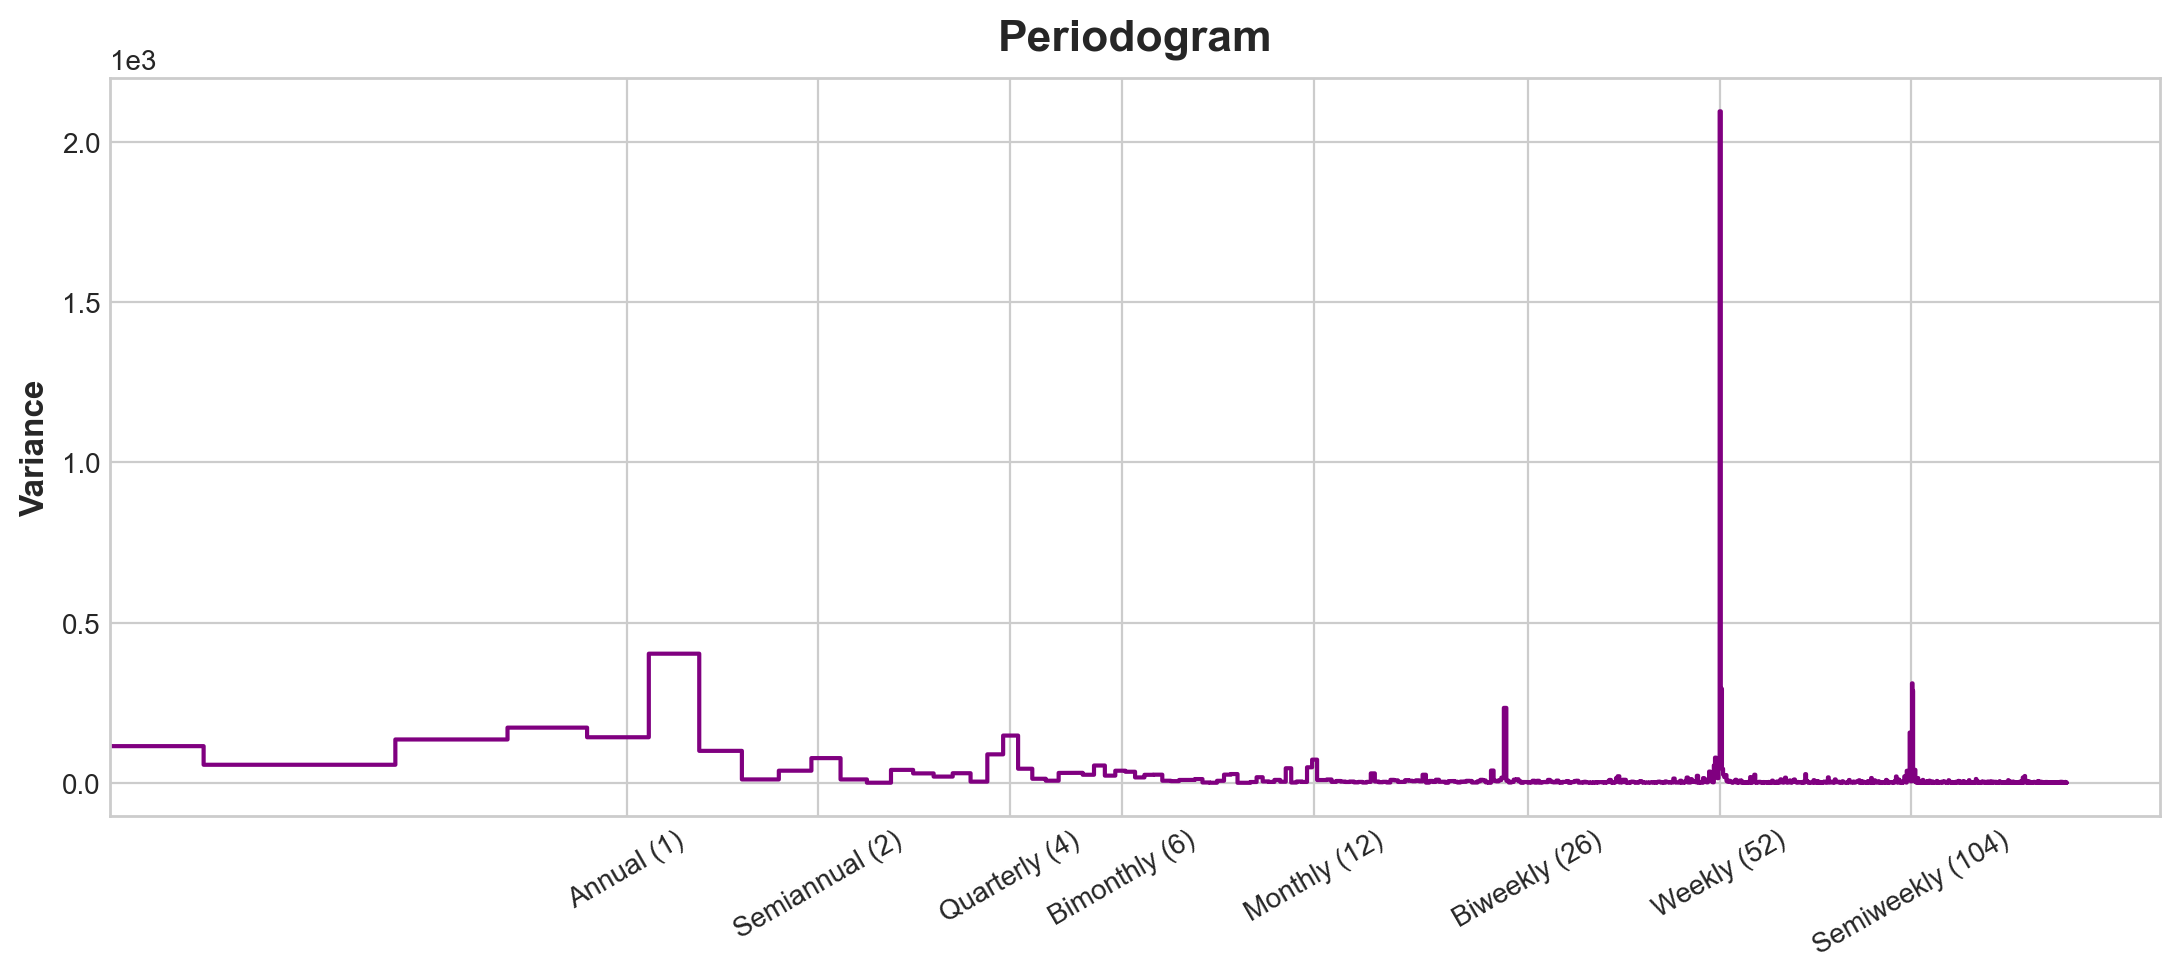

In [36]:
plot_periodogram(average_sales['sales'])

In [37]:
final_average_sales = final_store_sales.groupby('date').mean().squeeze()

In [38]:
y_plot = final_average_sales.loc[final_average_sales.index>='2015-06-01'].copy()


fourier = CalendarFourier(freq='W',order=4)
dp = DeterministicProcess(
    index=y_plot.index,
    constant=True,
    order=1,

    seasonal = True,
    additional_terms=[fourier],
    drop=True,
)
X_plot = dp.in_sample()

In [39]:
model_plot = LinearRegression().fit(X_plot, y_plot)
y_pred_plot = pd.Series(
    model_plot.predict(X_plot),
    index=X_plot.index,
    name='Fitted',
)

y_pred_plot = pd.Series(model_plot.predict(X_plot), index=X_plot.index)

In [40]:
y_deseason = y_plot - y_pred_plot

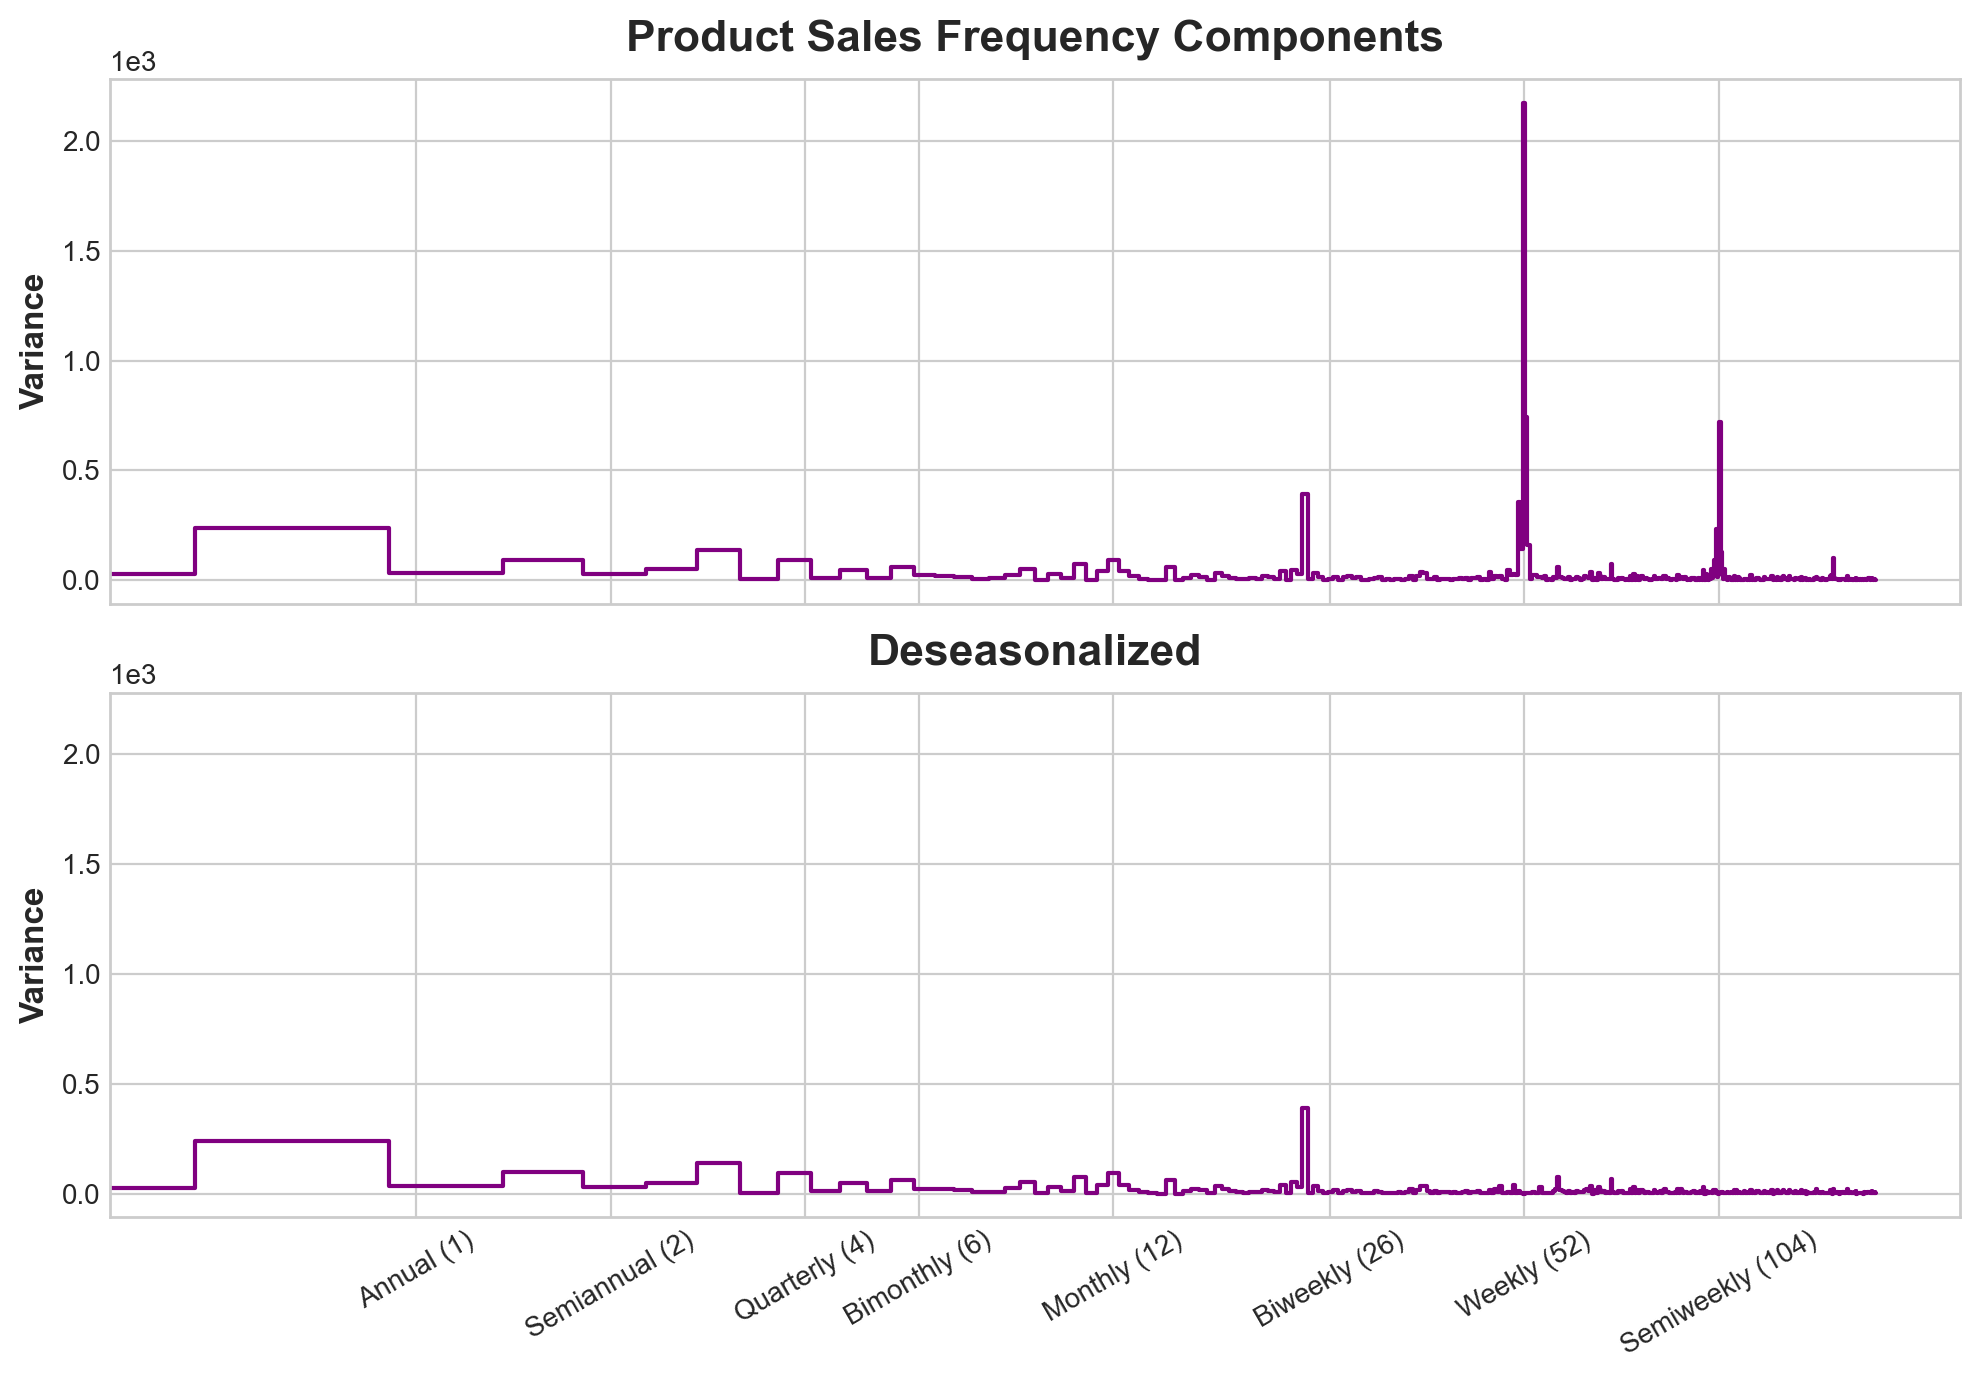

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_plot, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [42]:
#Very well caught weekly trend

# Simple Train

In [43]:
y = final_store_sales.unstack(['store_nbr','family'])
y = y.loc[common_index]

In [44]:
fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [45]:
df_train_man = df_train_copy.copy()
df_train_man = df_train_man.drop(['id','store_nbr','family','sales','day',
                            'month','quarter','dayoftheweek'],axis=1)

In [46]:
df_train_join = df_train_man.groupby('date').mean()
df_train_join = df_train_join.reset_index()
df_train_join['date'] = df_train_join['date'].dt.to_period('D')
df_train_join = df_train_join.groupby('date').mean()
df_train_join=df_train_join.loc[common_index]

In [47]:
X = X.join(df_train_join)

In [48]:
simple_model = LinearRegression(fit_intercept=False)
simple_model.fit(X, y)

LinearRegression(fit_intercept=False)

In [49]:
y_pred = pd.DataFrame(simple_model.predict(X), index=X.index, columns=y.columns)

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')

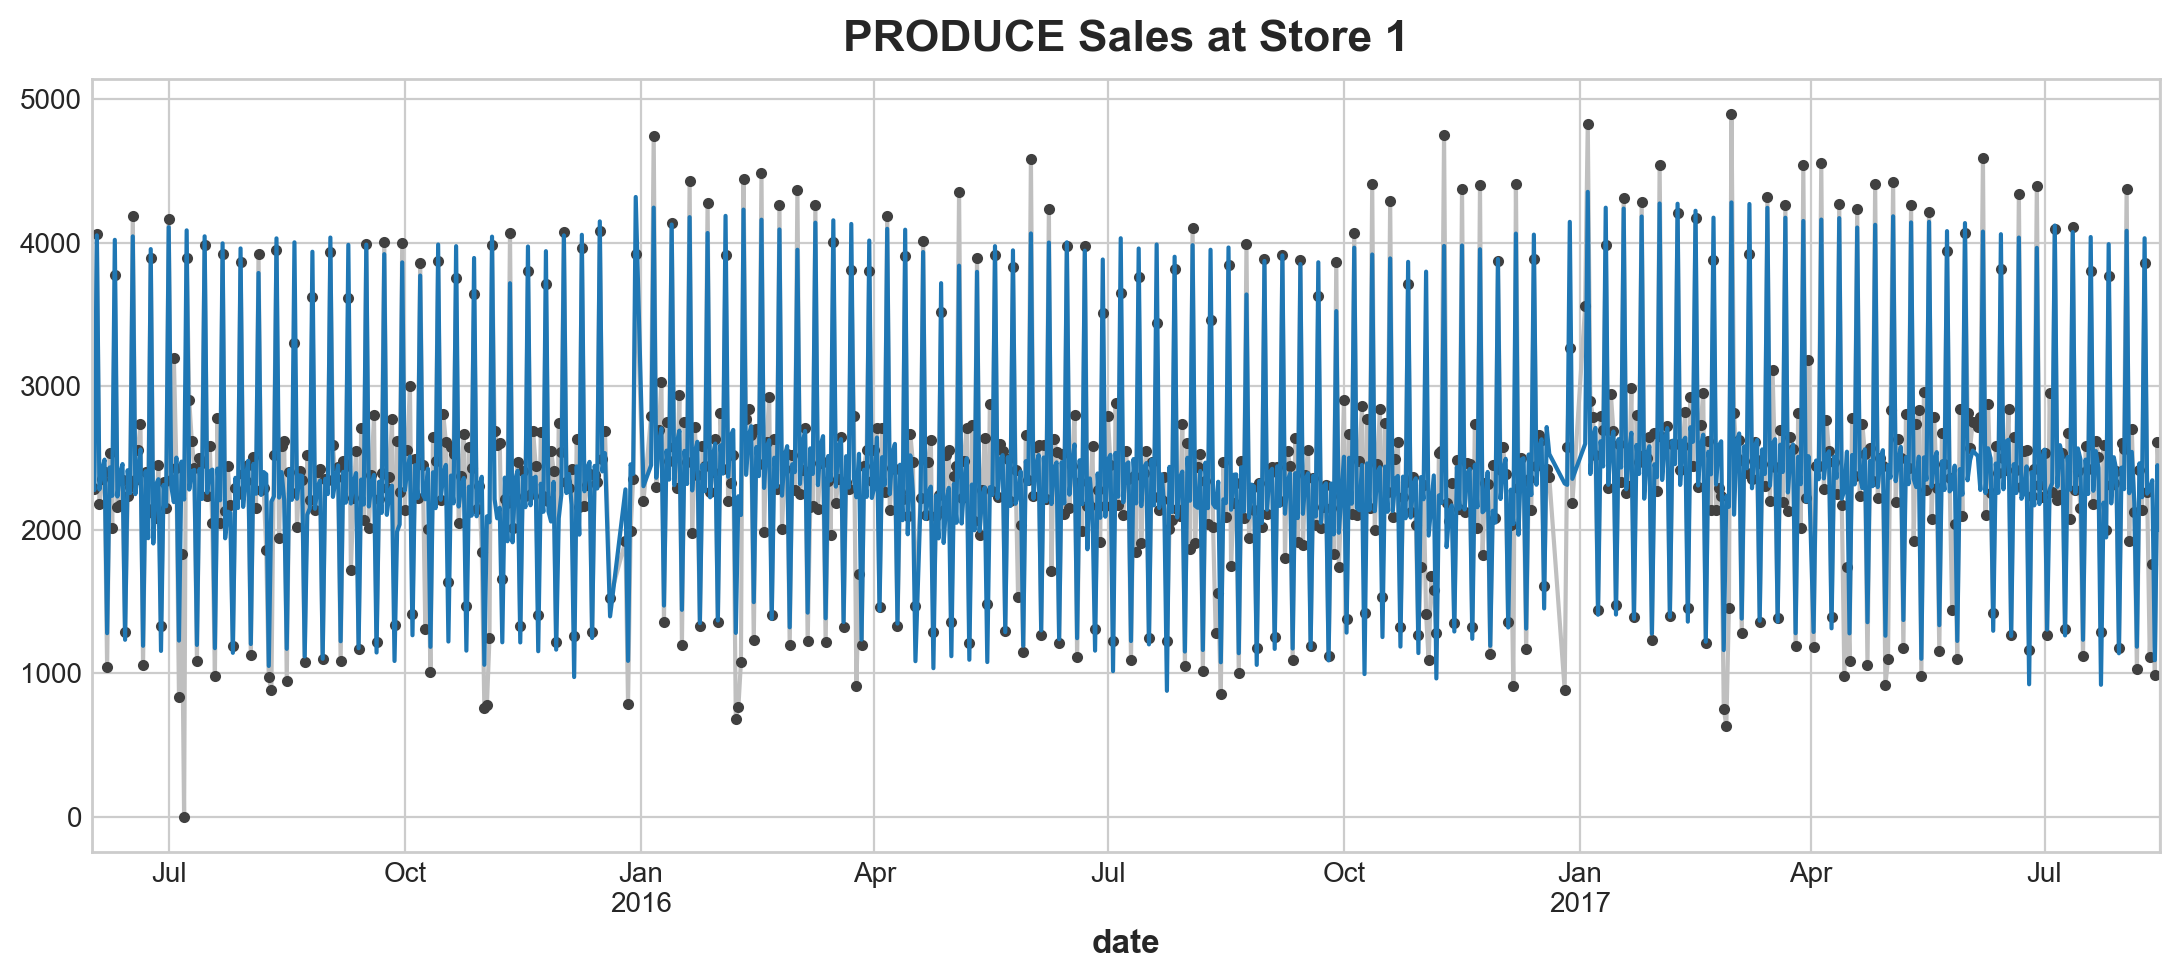

In [50]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'

display(final_store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

# Model Selection

In [51]:
lin_reg = LinearRegression() 
tree_reg = DecisionTreeRegressor() 
forest_reg = RandomForestRegressor() 
ridge_reg = Ridge() 
lasso_reg = Lasso() 
elasticnet_reg = ElasticNet()

models_list = {'Linear_Regression':lin_reg,
               'Decision_Tree':tree_reg, 
               'Random_Forest':forest_reg, 
               'Ridge_Regression':ridge_reg,
               'Lasso_Regression':lasso_reg, 
               'ElasticNet_Regression':elasticnet_reg
              }

In [52]:
#train basic models
def basic_models(df_results,datasetname ,models, cv_method, features_train, target_train):
    from sklearn.metrics import mean_squared_log_error
    from sklearn.model_selection import cross_val_score
    
    scoring = 'neg_mean_squared_log_error'
    cv = 10
    df_final = df_results.copy()
    for key, model in models.items():
        print(f'training model {key}')
        
        if cv_method == 'timeseriessplit':
            predictions = []
            rmse = []
            ts = TimeSeriesSplit(n_splits=10)
            for train_index, test_index in ts.split(features_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                tm_predict_clipped = np.clip(tm_predict, a_min=0, a_max=None)
                prediction = np.sqrt(mean_squared_log_error(test_y, tm_predict_clipped))
                rmse.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_prediction_mean': [np.min(predictions)],
                 'rmse_mean': np.mean(rmse),
                 'rmse_std': np.std(rmse),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
            
        
        df_row = pd.DataFrame(
            {'datasetname': [df_full_results.loc[0]['datasetname']] ,
             'model': [df_full_results.loc[0]['model']] ,
             'cv_method': [df_full_results.loc[0]['cv_method']],
             'basic_prediction_mean': [df_full_results['basic_prediction_mean'].mean()],
             'rmse_mean': [df_full_results.loc[0]['rmse_mean']],
             'rmse_std': [df_full_results.loc[0]['rmse_std']],
             'parameters': 'None'})
        
        
        df_final = pd.concat([df_final,df_row], axis=0, ignore_index=True)
    return df_final

In [53]:
#dataframe for holding training results
df_results = pd.DataFrame(columns=['datasetname',
                                   'model',
                                   'cv_method',
                                   'basic_prediction_mean',
                                   'rmse_mean',
                                   'rmse_std',
                                   'parameters'])

In [54]:
#evaluation methods
eval_methods = ['timeseriessplit']

In [55]:
#models trainer
def train_models(df_results, dataframes_dict, eval_methods, models_list):

    final_result = []

    #for key,value in dataframes_dict.items():
        #features_train = value.drop('', axis=1)
        #target_train = value['']
        
        
    features_train = dataframes_dict['features_train']
    target_train = dataframes_dict['target_train']
    key='current_data'    
    print(f'training data: {key}')
    for method in eval_methods:
        print(f'training method: {method}')
        result = basic_models(df_results,key, models_list, method, features_train, target_train)
        final_result.append(result)
        print('done method')
    print('done data')

    final_data_of_trained_models = pd.concat(final_result, axis=0)
    return final_data_of_trained_models

In [56]:
#dataframes dict
dataframes_dict = {'features_train':X,'target_train':y}

In [57]:
#train models
df_models_trained_no_params = train_models(df_results,dataframes_dict,eval_methods,models_list)

training data: current_data
training method: timeseriessplit
training model Linear_Regression
training model Decision_Tree
training model Random_Forest
training model Ridge_Regression
training model Lasso_Regression
training model ElasticNet_Regression
done method
done data


In [58]:
df_models_trained_no_params.sort_values(by='rmse_mean')

,datasetname,model,cv_method,basic_prediction_mean,rmse_mean,rmse_std,parameters
2,current_data,Random_Forest,timeseriessplit,0.471302,0.607839,0.143466,None
5,current_data,ElasticNet_Regression,timeseriessplit,0.511313,0.655822,0.139248,None
4,current_data,Lasso_Regression,timeseriessplit,0.545986,0.712484,0.122654,None
3,current_data,Ridge_Regression,timeseriessplit,0.557715,0.747910,0.125727,None
1,current_data,Decision_Tree,timeseriessplit,0.618885,0.783597,0.109670,None
0,current_data,Linear_Regression,timeseriessplit,0.558957,0.905317,0.341154,None


# Basic  Predict 

In [59]:
test_store_sales = df_test.copy()
test_store_sales['date'] = test_store_sales['date'].dt.to_period('D')
test_store_sales = test_store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [60]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

In [61]:
df_test_man = df_test_copy.copy()
df_test_man = df_test_man.drop(['id','store_nbr','family','day','month','quarter','dayoftheweek'],axis=1)

In [62]:
df_test_join = df_test_man.groupby('date').mean()
df_test_join = df_test_join.reset_index()
df_test_join['date'] = df_test_join['date'].dt.to_period('D')
df_test_join = df_test_join.groupby('date').mean()

In [63]:
X_test = X_test.join(df_test_join)

In [64]:
rfr = RandomForestRegressor()

In [65]:
rfr.fit(X,y)

RandomForestRegressor()

In [66]:
y_submit = pd.DataFrame(rfr.predict(X_test), index=X_test.index, columns=y.columns)

In [67]:
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(test_store_sales.id).reindex(columns=['id', 'sales'])

In [68]:
test_submit = y_submit.set_index('id')[['sales']].reset_index()
test_submit

,id,sales
0,3000888,3.220000
1,3000889,0.000000
2,3000890,3.420000
3,3000891,2501.710000
4,3000892,0.410000
...,...,...
28507,3029395,471.927076
28508,3029396,96.997280
28509,3029397,1656.237069
28510,3029398,75.500000


In [69]:
#test_submit.to_csv('submission_test_rfr_test.csv', index=False)

In [70]:
fi=pd.DataFrame(data=rfr.feature_importances_,
             index=rfr.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance', ascending=False)

,importance
transactions,0.357918
trend,0.109468
"sin(1,freq=W-SUN)",0.100411
dayoftheweek_y,0.066485
dayofthemonth_y,0.058473
onpromotion,0.048478
dayofthemonth_x,0.030918
month_x,0.027071
month_y,0.021604
"sin(2,freq=W-SUN)",0.021208


In [71]:
y_rfr = pd.DataFrame(rfr.predict(X), index=X.index, columns=y.columns)

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')

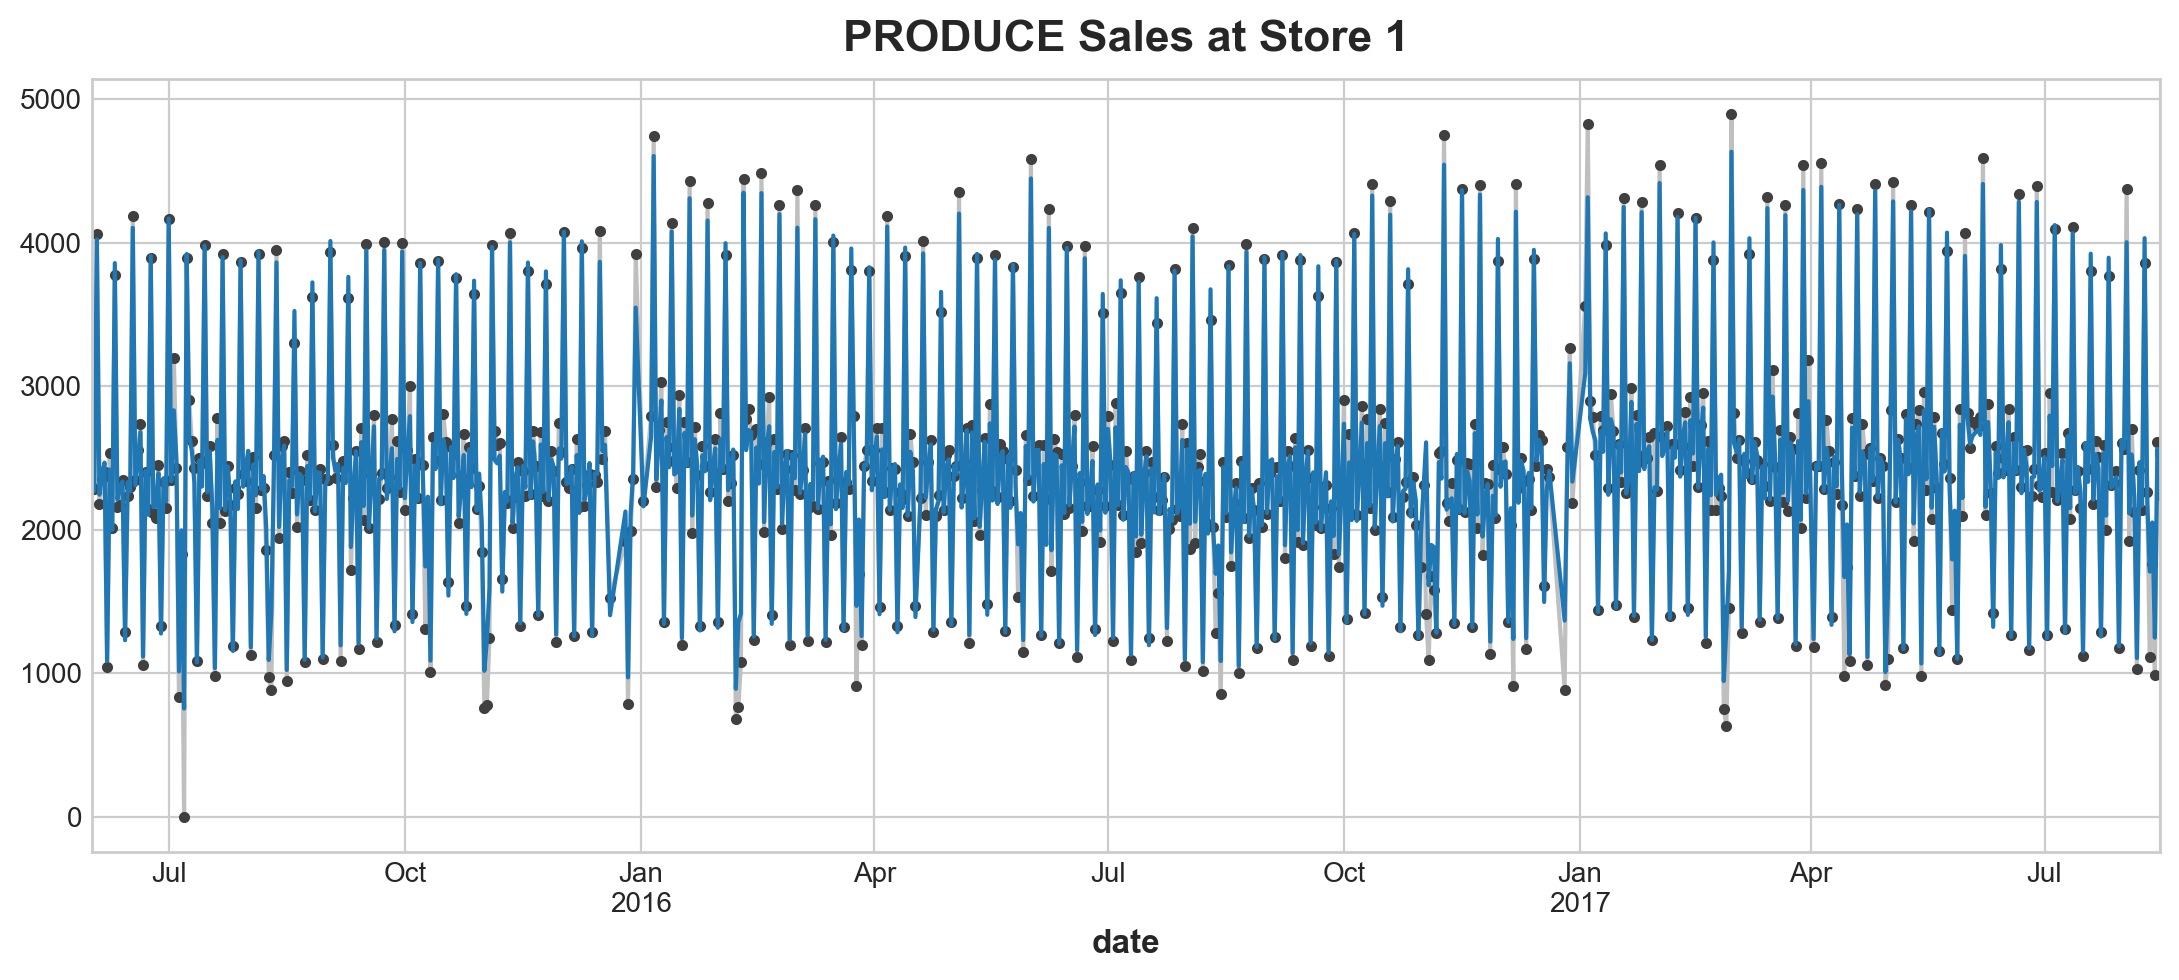

In [72]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'

display(final_store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_rfr.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

# Train Model Params

In [73]:
final_models_list = {'RandomForestRegressor':rfr}

In [74]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],         
    'max_depth': [10, 20, 30, 40, None],               
    'min_samples_split': [2, 5, 10],                   
    'min_samples_leaf': [1, 2, 4],                      
    'max_features': [1.0, 'sqrt', 'log2'],             
    'bootstrap': [True, False],                        
    'criterion': ['squared_error', 'absolute_error']   
}

In [ ]:
grid_search = GridSearchCV(rfr, param_grid, cv=2, scoring='neg_mean_squared_log_error', n_jobs=-1, verbose=2)


grid_search.fit(X, y)
print("best_params: ", grid_search.best_params_)

Fitting 2 folds for each of 2700 candidates, totalling 5400 fits


In [ ]:
print("best_params: ", grid_search.best_params_)

In [ ]:
#not enough processing power for gridsearch, randomsearch made worse prediction
#so basic model with prdiction of 0.45220